In [1]:
# Import necessary libraries for data handling, model utilization, and visualization
import numpy as np
import pandas as pd
import yfinance as yf  # For collecting financial data
import matplotlib.pyplot as plt
from typing import List, Dict, Optional, Tuple
from scipy.optimize import minimize 
from datetime import datetime, timedelta
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from collections import deque
# Import the custom Model class
from Model import Model

# Set the random seed for reproducibility across numpy and tensorflow
np.random.seed(123)

# Optional: Configure plotting style for a consistent look
plt.style.use('seaborn-darkgrid')

# Define the tickers and date range with consideration of trading days
TICKERS = ['VTI','AGG','DBC','VIXY']  # Example tickers for the portfolio
START_DATE = '2019-01-01'
END_DATE = "2024-01-01"  # Replace this with your actual END_DATE if it's variable
end_date_dt = pd.to_datetime(END_DATE)
start_date_6_month_dt = end_date_dt - pd.DateOffset(months=6)
start_date_6_month = start_date_6_month_dt.strftime('%Y-%m-%d')
end_date_6_month = end_date_dt.strftime('%Y-%m-%d')

# Approximate number of trading days per year (useful for annualizing returns)
TRADING_DAYS_PER_YEAR = 252

# Confirm setup
print("Setup complete: libraries imported, random seed set, and tickers defined.")


Setup complete: libraries imported, random seed set, and tickers defined.


C:\Users\wiztu\AppData\Local\Temp\ipykernel_38540\4173998976.py:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [2]:
# Data Collection Step
# Objective: Fetch historical adjusted close prices for defined tickers and date range

# Download data using yfinance for the specified tickers and date range
def get_data(tickers, start_date, end_date):
    """
    Retrieves historical adjusted close prices for the given tickers and date range.
    
    Parameters:
    - tickers: List of stock ticker symbols
    - start_date: Start date for historical data
    - end_date: End date for historical data
    
    Returns:
    - DataFrame of adjusted close prices, with each column representing a ticker
    """
    # Fetch data from yfinance
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    
    # Drop rows with missing values, if any, to ensure data continuity
    data.dropna(inplace=True)
    
    return data

# Fetch the data and display a quick preview
data = get_data(TICKERS, START_DATE, END_DATE)
print("Data fetched successfully. Sample data:")
print(data.head())

# Confirm data spans the expected range and has the expected number of columns
print(f"Data covers {len(data)} trading days with {len(data.columns)} assets.")


[*********************100%%**********************]  4 of 4 completed

Data fetched successfully. Sample data:
Ticker            AGG        DBC         VIXY         VTI
Date                                                     
2019-01-02  91.825172  13.549266  2996.800049  116.516754
2019-01-03  92.204277  13.661165  3137.600098  113.816597
2019-01-04  91.928574  13.847668  2885.600098  117.584015
2019-01-07  91.773468  13.950242  2824.800049  118.769882
2019-01-08  91.704544  14.090117  2765.600098  119.992271
Data covers 1258 trading days with 4 assets.


In [3]:
# Data Preprocessing Step
# Objective: Prepare data by calculating daily returns and normalizing for model input

def preprocess_data(data):
    """
    Prepares data for the LSTM model by calculating returns and normalizing prices.

    Parameters:
    - data: DataFrame of historical adjusted close prices for assets

    Returns:
    - normalized_data: DataFrame with prices normalized to start at 1 for each asset
    - returns: DataFrame with daily returns for each asset
    """
    # Calculate daily returns as percentage changes
    returns = data.pct_change().dropna()
    
    # Normalize prices so each series starts at 1
    normalized_data = data / data.iloc[0]
    
    return normalized_data, returns

# Run preprocessing and display sample data
normalized_data, returns = preprocess_data(data)
print("Data preprocessing complete. Sample normalized data:")
print(normalized_data.head())
print("\nSample daily returns:")
print(returns.head())


Data preprocessing complete. Sample normalized data:
Ticker           AGG       DBC      VIXY       VTI
Date                                              
2019-01-02  1.000000  1.000000  1.000000  1.000000
2019-01-03  1.004129  1.008259  1.046983  0.976826
2019-01-04  1.001126  1.022023  0.962894  1.009160
2019-01-07  0.999437  1.029594  0.942605  1.019337
2019-01-08  0.998686  1.039917  0.922851  1.029828

Sample daily returns:
Ticker           AGG       DBC      VIXY       VTI
Date                                              
2019-01-03  0.004129  0.008259  0.046983 -0.023174
2019-01-04 -0.002990  0.013652 -0.080316  0.033101
2019-01-07 -0.001687  0.007407 -0.021070  0.010085
2019-01-08 -0.000751  0.010027 -0.020957  0.010292
2019-01-09  0.000846  0.019854 -0.023141  0.004713


In [4]:
class Portfolio:
    def __init__(self, initial_cash: float, assets: pd.DataFrame):
        """
        Initializes the Portfolio object.

        Parameters:
        - initial_cash: The starting value of the portfolio in cash.
        - assets: DataFrame of asset prices (historical data).
        """
        self.initial_cash = initial_cash
        self.current_value = initial_cash
        self.assets = assets  # Historical price data for the assets
        self.weights = np.zeros(len(assets.columns))  # Initialize weights as zero
        self.portfolio_history = []  # To track portfolio value over time
        self.rebalancing_dates = []  # To store rebalancing dates

    def rebalance(self, new_weights: np.array):
        """
        Rebalances the portfolio according to new weights.

        Parameters:
        - new_weights: Numpy array of asset allocations.
        """
        if len(new_weights) != len(self.assets.columns):
            raise ValueError("Number of weights must match the number of assets.")
        self.weights = new_weights

    def calculate_initial_shares(self, initial_cash, initial_prices):
        """
        Calculates the number of shares for each asset at the start of the testing period based on
        initial cash and allocation weights.

        Parameters:
        - initial_cash: The starting cash value of the portfolio.

        Returns:
        - shares: Dictionary with tickers as keys and the initial number of shares as values.
        """
        # Calculate the dollar amount allocated to each asset
        dollar_allocation = initial_cash * self.weights

        # Calculate the number of shares for each asset
        shares = (dollar_allocation // initial_prices).astype(int)  # Floor division to get whole shares

        # Return as a dictionary for easy readability
        return dict(zip(self.assets.columns, shares))
    
    def calculate_daily_returns(self):
        """
        Applies the current weights to asset returns and updates portfolio value over time.
        """
        # Calculate daily returns for each asset
        daily_returns = self.assets.pct_change().dropna()
        
        # Calculate portfolio returns by applying weights
        portfolio_returns = np.dot(daily_returns, self.weights)

        # Track the portfolio's value over time by compounding the returns
        for daily_ret in portfolio_returns:
            self.current_value *= (1 + daily_ret)
            self.portfolio_history.append(self.current_value)

    def track_portfolio_performance(self):
        """
        Tracks and prints the portfolio performance over time.
        """
        for date, value in zip(self.assets.index[1:], self.portfolio_history):
            print(f"Date: {date}, Portfolio Value: {value}")

    def step(self, action):
        normalized_action = np.array(action) / np.sum(action)
        
        self.rebalance(normalized_action)
        portfolio_returns = self.calculate_daily_returns()

        self.current_value *= (1 + portfolio_returns[-1])
        self.portfolio_history.append(self.current_value)

        daily_returns = np.array(self.portfolio_history)
        returns = daily_returns[1:] / daily_returns[:-1] - 1
        mean_returns = np.mean(returns)
        std_returns = np.std(returns)
        reward = mean_returns / std_returns if std_returns != 0 else 0

        normalized_prices = self.assets / self.assets.iloc[0]
        next_state = normalized_prices.values[-1]

        done = self.current_value <= self.initial_cash * 0.75

        return next_state, reward, done
    
    def reset(self):
        self.current_cash = self.initial_cash
        self.assets = self.initial_assets.copy()
        self.weights = np.zeros(len(self.assets.columns))  # Reset to no investments
        self.portfolio_history = []
        self.rebalancing_dates = []
        return self.assets.iloc[0].values

    def get_portfolio_value(self):
        """
        Returns the current value of the portfolio.
        """
        return self.current_value
    
    def plot_portfolio_value(self):
        """
        Plots the portfolio value over time.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(self.assets.index[1:], self.portfolio_history, label="Portfolio Value")
        plt.title("Portfolio Value Over Time")
        plt.xlabel("Date")
        plt.ylabel("Portfolio Value")
        plt.legend()
        plt.show()

In [ ]:
def train_and_rebalance_portfolio(portfolio: Portfolio, frequency: int, model: Model):
    """
    Trains the LSTM model and rebalances the portfolio at the end of each specified interval.

    Parameters:
    - portfolio: An instance of the Portfolio class.
    - frequency: The frequency of rebalancing in days.
    - model: An instance of the Model class for training.
    """
    num_days = len(portfolio.assets)
    start_index = 0

    while start_index < num_days:
        # Determine the end index for the current training period
        end_index = min(start_index + frequency, num_days)

        # Slice the data for the training period
        train_data = portfolio.assets.iloc[start_index:end_index]

        # Preprocess the training data
        normalized_data, _ = preprocess_data(train_data)

        # Get allocations from the model
        allocations = model.get_allocations(normalized_data)

        # Rebalance the portfolio with the optimized weights
        portfolio.rebalance(allocations)

        # Store the rebalancing date
        portfolio.rebalancing_dates.append(train_data.index[-1])

        # Move to the next period
        start_index += frequency
    return allocations

def lstm_allocation_strategy(train_data, rebalance_frequency=20):
    """
    Uses train_and_rebalance_portfolio to generate optimized allocations with periodic rebalancing.

    Parameters:
    - train_data: DataFrame of normalized prices for training.
    - rebalance_frequency: Frequency of rebalancing within the training period.

    Returns:
    - final_allocations: Array of optimized weights for each asset.
    """
    model = Model()
    training_portfolio = Portfolio(initial_cash=100000, assets=train_data)
    final_allocations = train_and_rebalance_portfolio(training_portfolio, frequency=rebalance_frequency, model=model)
    return final_allocations



In [6]:
def calculate_metrics(portfolio_values):
    """
    Calculates performance metrics for the portfolio.

    Parameters:
    - portfolio_values: List of daily portfolio values over the testing period.

    Returns:
    - metrics: Dictionary containing Sharpe Ratio, Sortino Ratio, and Max Drawdown.
    """
    # Convert portfolio values to daily returns
    portfolio_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    
    # Calculate Sharpe Ratio
    mean_return = np.mean(portfolio_returns)
    std_dev = np.std(portfolio_returns)
    sharpe_ratio = mean_return / std_dev * np.sqrt(TRADING_DAYS_PER_YEAR)
    
    # Calculate Sortino Ratio
    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_std_dev = np.std(downside_returns)
    sortino_ratio = mean_return / downside_std_dev * np.sqrt(TRADING_DAYS_PER_YEAR)
    
    # Calculate Maximum Drawdown
    cumulative_returns = np.maximum.accumulate(portfolio_values) - portfolio_values
    max_drawdown = np.max(cumulative_returns / np.maximum.accumulate(portfolio_values))
    
    return {
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown
    }

def calculate_expected_annual_return_with_actual_prices(final_allocations, start_date, end_date, initial_cash):
    """
    Buys stock at the actual start price for the six-month period and calculates expected annual return.
    
    Parameters:
    - final_allocations: Numpy array of final asset allocations.
    - start_date: Start date for the 6-month period before the testing end date.
    - end_date: End date for the 6-month period.
    - initial_cash: The starting cash amount for the new portfolio.
    
    Returns:
    - expected_annual_return: Extrapolated annual return based on the 6-month performance.
    """
    # Fetch actual price data for the six-month period
    data_6_month = get_data(TICKERS, start_date, end_date)
    
    # Get initial prices to buy shares
    initial_prices = data_6_month.iloc[0]  # First row gives prices on the start date
    
    # Calculate dollar allocation per asset
    dollar_allocations = final_allocations * initial_cash
    
    # Calculate shares purchased for each asset
    shares = dollar_allocations / initial_prices
    
    # Track portfolio value over the six-month period using actual prices
    portfolio_values = data_6_month.dot(shares)
    
    # Calculate the total return over the six-month period
    total_return_6_month = (portfolio_values.iloc[-1] / portfolio_values.iloc[0]) - 1
    
    # Annualize the return
    expected_annual_return = (1 + total_return_6_month) ** (12 / 6) - 1
    
    return expected_annual_return


In [11]:
def equal_weighted_strategy(returns):
    """
    Creates an equal-weighted portfolio.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - equal_weights: Numpy array of equal weights for each asset.
    """
    num_assets = returns.shape[1]
    equal_weights = np.ones(num_assets) / num_assets
    return equal_weights

def mean_variance_optimized_strategy(returns):
    """
    Creates a mean-variance optimized portfolio by maximizing the Sharpe Ratio.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - optimized_weights: Numpy array of optimized weights for each asset.
    """
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    
    def neg_sharpe(weights):
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -portfolio_return / portfolio_std

    # Constraints: Weights must sum to 1, and each weight must be between 0 and 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(returns.shape[1]))

    result = minimize(neg_sharpe, np.ones(returns.shape[1]) / returns.shape[1], bounds=bounds, constraints=constraints)
    optimized_weights = result.x
    
    return optimized_weights

[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Epoch 1/20



c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.5285
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.3896
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1693
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: -0.0590
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: -0.1846
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: -0.2292
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: -0.2457
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: -0.2537
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: -0.2586
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: -0.2617
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: -0.2638
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: -0.2654
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: -0.2668
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: -0.2683
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: -0.2701
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━

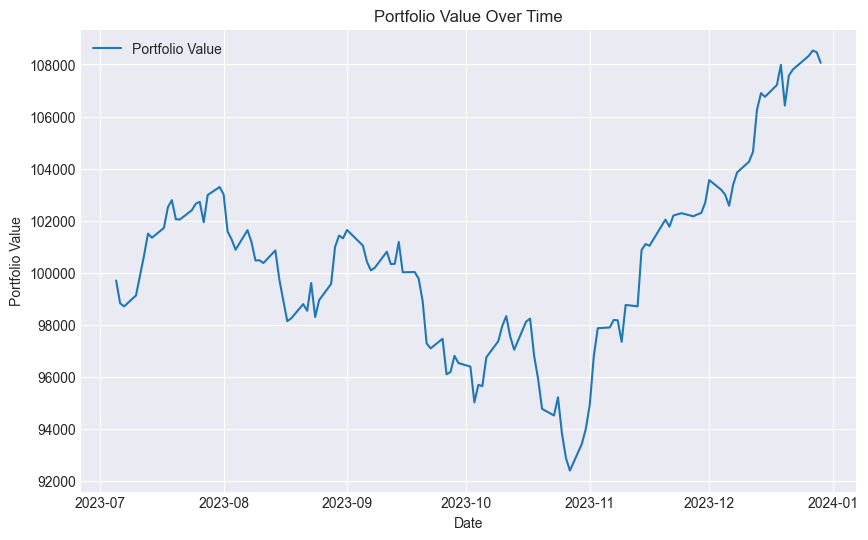

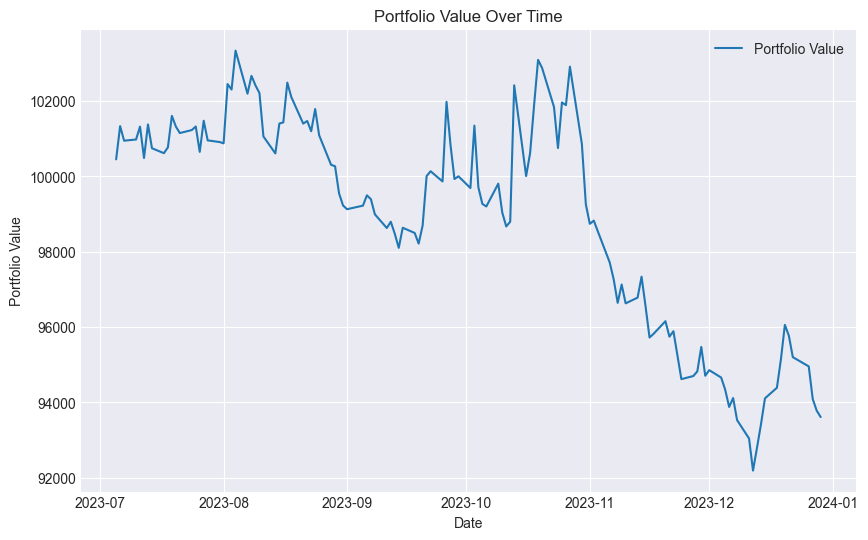

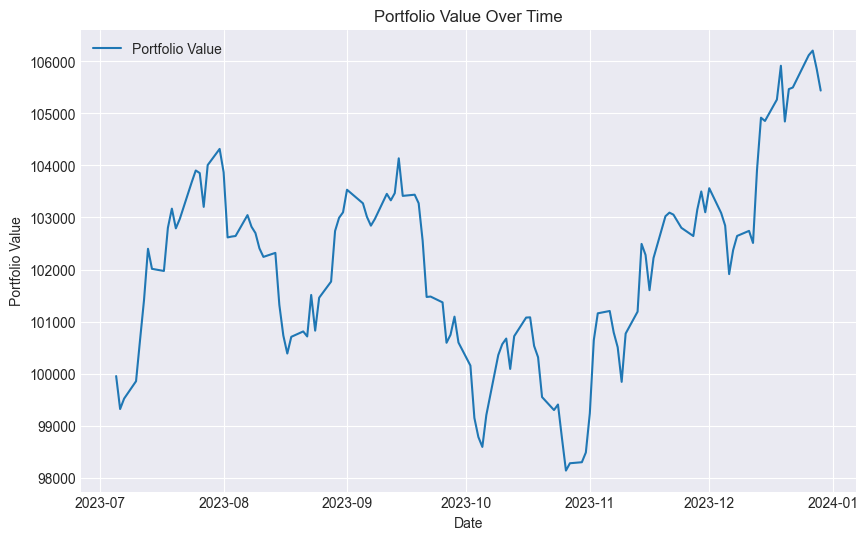

[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]


LSTM Portfolio Metrics:
Weights:[0.01651549 0.00218423 0.00153619 0.9797641 ], Shares:{'AGG': 17, 'DBC': 10, 'VIXY': 1, 'VTI': 451}
{'Sharpe Ratio': 1.4416469708694126, 'Sortino Ratio': 2.29292076463408, 'Max Drawdown': 0.10544432692931059}
Expected Annual Return: 0.16772940417305193

Equal-Weighted Portfolio Metrics:
Weights:[0.25 0.25 0.25 0.25], Shares:{'AGG': 267, 'DBC': 1155, 'VIXY': 252, 'VTI': 115}
{'Sharpe Ratio': -1.0649261073920075, 'Sortino Ratio': -1.8894100142550632, 'Max Drawdown': 0.10790483287153739}
Expected Annual Return: -0.11559553155014457

Mean-Variance Optimized Portfolio Metrics:
Weights:[2.02593316e-01 3.08964209e-01 2.16840434e-19 4.88442475e-01], Shares:{'AGG': 217, 'DBC': 1427, 'VIXY': 0, 'VTI': 225}
{'Sharpe Ratio': 1.3045137431739495, 'Sortino Ratio': 2.4380062109521123, 'Max Drawdown': 0.059275338908804154}


[*********************100%%**********************]  4 of 4 completed

Expected Annual Return: 0.10860323390021498


In [13]:
# Step 1: Data Preparation for Training and Testing
train_data = get_data(TICKERS, START_DATE, END_DATE)
normalized_train_data, training_returns = preprocess_data(train_data)

testing_data = get_data(TICKERS, start_date_6_month, end_date_6_month)
normalized_testing_data, testing_returns = preprocess_data(testing_data)

# Step 2: Train and Rebalance Portfolio in Training Phase (rebalancing every two years)
training_portfolio = Portfolio(100000, normalized_train_data)
model = Model()
initial_prices = testing_data.loc[testing_data.index[0]]  # First row of the actual price data
# Rebalance every 2 years (252 trading days * 2)
final_allocations = train_and_rebalance_portfolio(training_portfolio, frequency=20, model=model)

# Step 3: Initialize Testing Portfolio with Final LSTM Weights
testing_portfolio = Portfolio(100000, normalized_testing_data)
testing_portfolio.rebalance(final_allocations)
LSTM_shares = testing_portfolio.calculate_initial_shares(100000,initial_prices)  # Calculate initial shares based on final allocations
testing_portfolio.calculate_daily_returns()     # Track performance in testing period
testing_portfolio.plot_portfolio_value()        # Visualize portfolio value over time
# Step 4: Calculate Performance Metrics for LSTM Portfolio
metrics = calculate_metrics(testing_portfolio.portfolio_history)

# Step 5: Baseline Strategies Setup and Evaluation
# Equal-Weighted and Mean-Variance Optimized Portfolios
equal_weights = equal_weighted_strategy(training_returns)
mv_optimized_weights = mean_variance_optimized_strategy(training_returns)

equal_weight_portfolio = Portfolio(100000, normalized_testing_data)
mv_optimized_portfolio = Portfolio(100000, normalized_testing_data)

equal_weight_portfolio.rebalance(equal_weights)
mv_optimized_portfolio.rebalance(mv_optimized_weights)

equal_weight_portfolio.calculate_daily_returns()
mv_optimized_portfolio.calculate_daily_returns()
ew_shares = equal_weight_portfolio.calculate_initial_shares(100000,initial_prices)
mv_shares = mv_optimized_portfolio.calculate_initial_shares(100000,initial_prices)
equal_weight_portfolio.plot_portfolio_value()
mv_optimized_portfolio.plot_portfolio_value()
# Step 6: Calculate Performance Metrics for Baseline Portfolios
equal_weight_metrics = calculate_metrics(equal_weight_portfolio.portfolio_history)
mv_optimized_metrics = calculate_metrics(mv_optimized_portfolio.portfolio_history)

# Step 7: Calculate Expected Annual Return with Actual Prices
start_date_6_month = '2023-07-01'
end_date_6_month = '2024-01-01'
expected_annual_return = calculate_expected_annual_return_with_actual_prices(final_allocations, start_date_6_month, end_date_6_month, 100000)
print("\nLSTM Portfolio Metrics:")
print(f"Weights:{final_allocations}, Shares:{LSTM_shares}")
print(metrics)
print(f"Expected Annual Return: {expected_annual_return}")

print("\nEqual-Weighted Portfolio Metrics:")
print(f"Weights:{equal_weights}, Shares:{ew_shares}")
print(equal_weight_metrics)
expected_annual_return_ew = calculate_expected_annual_return_with_actual_prices(equal_weights, start_date_6_month, end_date_6_month, 100000)
print(f"Expected Annual Return: {expected_annual_return_ew}")

print("\nMean-Variance Optimized Portfolio Metrics:")
print(f"Weights:{mv_optimized_weights}, Shares:{mv_shares}")
print(mv_optimized_metrics)
expected_annual_return_mv = calculate_expected_annual_return_with_actual_prices(mv_optimized_weights, start_date_6_month, end_date_6_month, 100000)
print(f"Expected Annual Return: {expected_annual_return_mv}")


Epoch 1/20


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.3365
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1061
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1307
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.2520
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.2871
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: -0.2960
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.2987
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.3001
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.3012
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.3022
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.3033
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.3046
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: -0.3061
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.3079
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.3100
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━

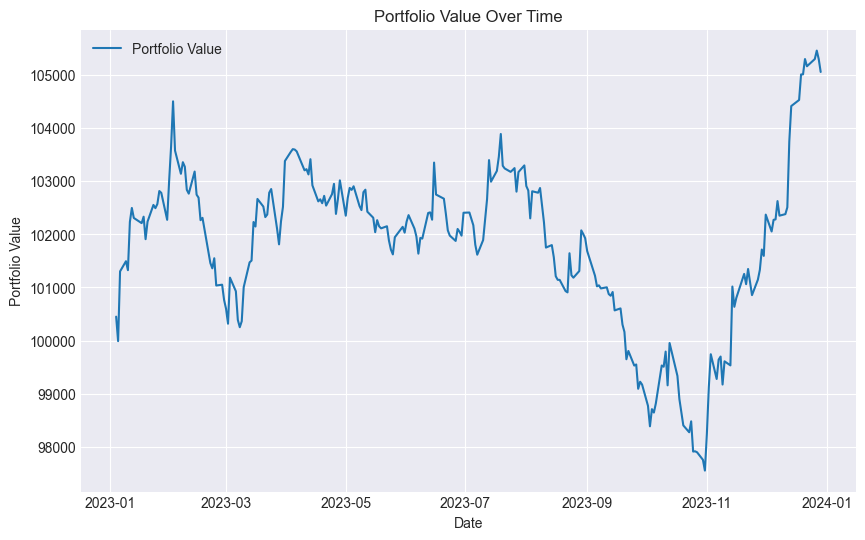

LSTM Portfolio Metrics:
Weights:[0.53388965 0.00123725 0.06540997 0.3994631 ], Shares:{'AGG': 582, 'DBC': 5, 'VIXY': 28, 'VTI': 215}
{'Sharpe Ratio': 0.7906241850434694, 'Sortino Ratio': 1.577144190915957, 'Max Drawdown': 0.06644320390098948}
Epoch 1/20


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.4780
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.3055
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0462
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: -0.1655
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: -0.2422
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: -0.2588
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: -0.2613
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: -0.2610
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.2606
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: -0.2607
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: -0.2613
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: -0.2625
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: -0.2640
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: -0.2660
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: -0.2682
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━

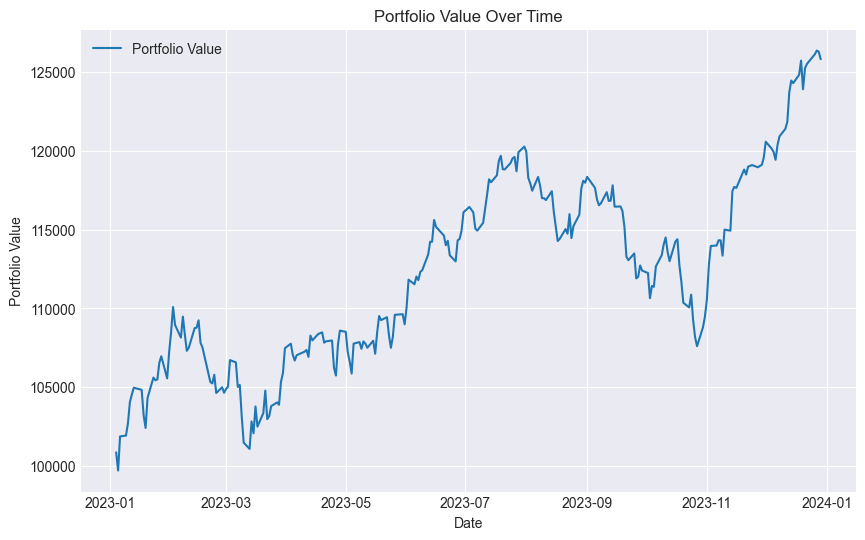

LSTM Portfolio Metrics:
Weights:[0.01763746 0.00232725 0.00170675 0.9783286 ], Shares:{'AGG': 19, 'DBC': 10, 'VIXY': 0, 'VTI': 527}
{'Sharpe Ratio': 1.769671477126402, 'Sortino Ratio': 2.9499656070288798, 'Max Drawdown': 0.10530211010550353}


In [20]:
#Comparison of performance with different training frequencies
model2 = Model()
training_portfolio = Portfolio(100000, normalized_train_data)
initial_prices = testing_data.loc[testing_data.index[0]]  # First row of the actual price data
# Rebalance every 2 years (252 trading days * 2)
final_allocations = train_and_rebalance_portfolio(training_portfolio, frequency=15, model=model2)

# Step 3: Initialize Testing Portfolio with Final LSTM Weights
testing_portfolio = Portfolio(100000, normalized_testing_data)
testing_portfolio.rebalance(final_allocations)
LSTM_shares = testing_portfolio.calculate_initial_shares(100000,initial_prices)  # Calculate initial shares based on final allocations
testing_portfolio.calculate_daily_returns()     # Track performance in testing period
testing_portfolio.plot_portfolio_value()        # Visualize portfolio value over time
# Step 4: Calculate Performance Metrics for LSTM Portfolio
metrics = calculate_metrics(testing_portfolio.portfolio_history)
print("LSTM Portfolio Metrics:")
print(f"Weights:{final_allocations}, Shares:{LSTM_shares}")
print(metrics)

model3 = Model()
training_portfolio = Portfolio(100000, normalized_train_data)
initial_prices = testing_data.loc[testing_data.index[0]]  # First row of the actual price data
# Rebalance every 2 years (252 trading days * 2)
final_allocations = train_and_rebalance_portfolio(training_portfolio, frequency=20, model=model3)

# Step 3: Initialize Testing Portfolio with Final LSTM Weights
testing_portfolio = Portfolio(100000, normalized_testing_data)
testing_portfolio.rebalance(final_allocations)
LSTM_shares = testing_portfolio.calculate_initial_shares(100000,initial_prices)  # Calculate initial shares based on final allocations
testing_portfolio.calculate_daily_returns()     # Track performance in testing period
testing_portfolio.plot_portfolio_value()        # Visualize portfolio value over time
# Step 4: Calculate Performance Metrics for LSTM Portfolio
metrics = calculate_metrics(testing_portfolio.portfolio_history)
print("LSTM Portfolio Metrics:")
print(f"Weights:{final_allocations}, Shares:{LSTM_shares}")
print(metrics)

## Testing clearly suggests a higher rebalancing frequency leads to better results, but with a greater risk of overfitting. I think opting for 20 days between rebalances would increase efficiency and reduce overfitting without sacrificing too much performance.


[*********************100%%**********************]  4 of 4 completed

Epoch 1/20



c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.4812
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.4120
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.3132
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1739
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: -0.0026
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: -0.1813
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: -0.3162
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: -0.4032
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: -0.4481
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: -0.4492
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: -0.4373
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: -0.4379
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: -0.4514
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: -0.4682
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: -0.4724
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━━

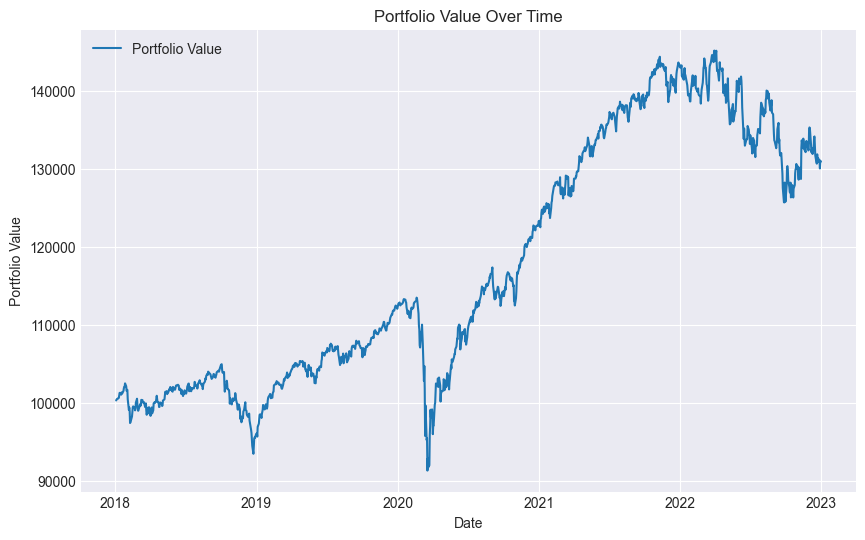

Test Metrics: {'Sharpe Ratio': 0.5574693043854214, 'Sortino Ratio': 0.6459959545788508, 'Max Drawdown': 0.19529487379926008}
Final Allocations: [0.44192556 0.2096892  0.00088832 0.34749687]


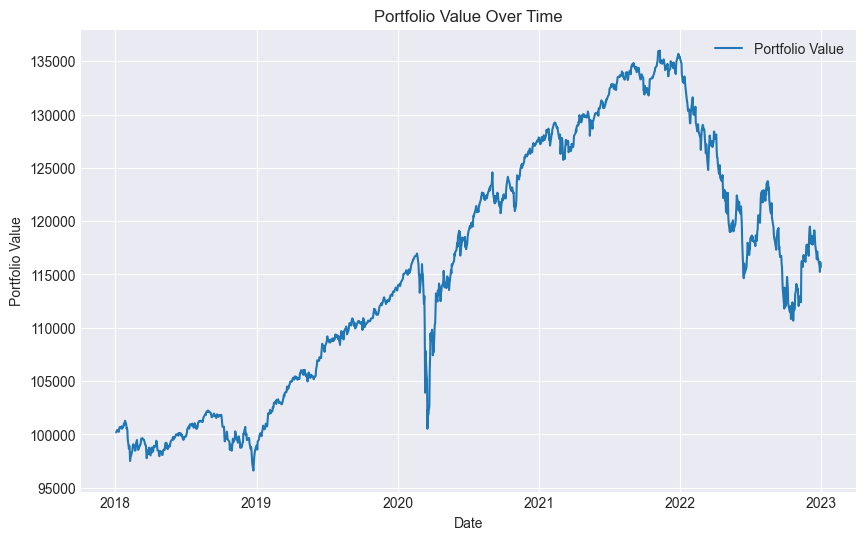

Mean-Variance Optimized Metrics: {'Sharpe Ratio': 0.3955783128468214, 'Sortino Ratio': 0.4463788959763867, 'Max Drawdown': 0.18634759908766918}
Mean-Variance Optimized Allocations: [7.06422743e-01 3.96638917e-15 0.00000000e+00 2.93577257e-01]


In [25]:
# Step 1: Fetch data for a 10-year period
tickers = ['VTI', 'AGG', 'DBC', 'VIXY']
start_date = '2013-01-01'  # Start date for 10 years of data
end_date = '2023-01-01'    # End date for testing
data = get_data(tickers, start_date, end_date)

# Step 2: Define train-test split (e.g., 50% for training, 50% for testing)
split_ratio = 0.5
split_index = int(len(data) * split_ratio)

# Step 3: Split and preprocess data
train_data = data.iloc[:split_index]
test_data = data.iloc[split_index:]

normalized_train, _ = preprocess_data(train_data)
normalized_test, _ = preprocess_data(test_data)

# Step 4: Train model on training data
model = Model()
training_portfolio = Portfolio(initial_cash=100000, assets=normalized_train)
training_returns = training_portfolio.assets.pct_change().dropna()
final_allocations = train_and_rebalance_portfolio(training_portfolio, frequency=20, model=model)

# Step 5: Test on the holdout set using final allocations
testing_portfolio = Portfolio(initial_cash=100000, assets=normalized_test)
testing_portfolio.rebalance(final_allocations)
testing_portfolio.calculate_daily_returns()
testing_portfolio.plot_portfolio_value()
# Calculate test performance metrics
metrics = calculate_metrics(testing_portfolio.portfolio_history)
print(f"Test Metrics: {metrics}")
print(f"Final Allocations: {final_allocations}")
# Step 6: Use mean-variance optimization for comparison
mv_optimized_weights = mean_variance_optimized_strategy(training_returns)
mv_optimized_portfolio = Portfolio(initial_cash=100000, assets=normalized_test)
mv_optimized_portfolio.rebalance(mv_optimized_weights)
mv_optimized_portfolio.calculate_daily_returns()
mv_optimized_portfolio.plot_portfolio_value()
mv_optimized_metrics = calculate_metrics(mv_optimized_portfolio.portfolio_history)
print(f"Mean-Variance Optimized Metrics: {mv_optimized_metrics}")
print(f"Mean-Variance Optimized Allocations: {mv_optimized_weights}")


In [26]:
def generalized_rolling_validation(data, allocation_strategy, train_years=5, test_months=6, initial_cash=100000, rebalance_frequency=30):
    """
    Performs rolling validation with a specified allocation strategy.
    
    Parameters:
    - data: DataFrame of historical prices.
    - allocation_strategy: Function that computes portfolio allocations based on training data.
    - train_years: Number of years for the training period in each roll.
    - test_months: Number of months for the testing period in each roll.
    - initial_cash: Initial investment amount.
    - rebalance_frequency: Frequency of rebalancing within the training period (for LSTM).

    Returns:
    - results: List of dictionaries with performance metrics for each roll.
    """
    results = []
    start_date = data.index[0]
    
    while True:
        # Define training and testing windows
        train_end = start_date + pd.DateOffset(years=train_years)
        test_start = train_end + timedelta(days=1)
        test_end = test_start + pd.DateOffset(months=test_months)
        
        # Stop if testing period exceeds available data
        if test_end > data.index[-1]:
            break
        
        # Split data into train and test sets for this roll
        train_data = data.loc[start_date:train_end]
        test_data = data.loc[test_start:test_end]
        
        # Preprocess the training and testing data
        normalized_train, train_returns = preprocess_data(train_data)
        normalized_test, _ = preprocess_data(test_data)
        
        # Conditional handling for strategy-specific allocation
        if allocation_strategy == train_and_rebalance_portfolio:
            # LSTM-based strategy with periodic rebalancing
            model = Model()
            training_portfolio = Portfolio(initial_cash=initial_cash, assets=normalized_train)
            final_allocations = allocation_strategy(training_portfolio, frequency=rebalance_frequency, model=model)
        else:
            # Non-LSTM strategy (e.g., equal-weighted or mean-variance) without periodic rebalancing
            if allocation_strategy == mean_variance_optimized_strategy:
                final_allocations = allocation_strategy(train_returns)  # Mean-variance uses returns
            else:
                final_allocations = allocation_strategy(normalized_train)  # Equal-weighted and other strategies use prices
        
        # Apply the final allocations to the test data
        testing_portfolio = Portfolio(initial_cash=initial_cash, assets=normalized_test)
        testing_portfolio.rebalance(final_allocations)
        testing_portfolio.calculate_daily_returns()
        
        # Calculate performance metrics for this roll
        metrics = calculate_metrics(testing_portfolio.portfolio_history)
        
        # Store results for this roll
        results.append({
            'train_period': (start_date, train_end),
            'test_period': (test_start, test_end),
            'metrics': metrics
        })
        
        # Move the start date forward for the next roll
        start_date = start_date + pd.DateOffset(months=test_months)
    
    return results


In [ ]:
# Define tickers and data parameters
tickers = ['VTI', 'AGG', 'DBC', 'VIXY']
data = get_data(tickers, '2013-01-01', '2023-01-01')

# Rolling validation with LSTM-based optimization (with periodic rebalancing)
lstm_results = generalized_rolling_validation(data, train_and_rebalance_portfolio, rebalance_frequency=20)
print("LSTM Results:", lstm_results)

# Rolling validation with equal-weighted strategy
equal_weight_results = generalized_rolling_validation(data, equal_weighted_strategy)
print("Equal-Weighted Results:", equal_weight_results)

# Rolling validation with mean-variance optimization
mvo_results = generalized_rolling_validation(data, mean_variance_optimized_strategy)
print("Mean-Variance Optimization Results:", mvo_results)


[*********************100%%**********************]  4 of 4 completed

Epoch 1/20



c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.4703
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.4013
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3167
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2285
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1529
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0994
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0668
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0487
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0385
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0314
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0246
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0174
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0104
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0053
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0036
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/st